In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn ofrece una variedad de modelos Naive Bayes. Para este problema, utilizamos MultinomialNB, que es adecuado para datos de conteo como este.
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
)

# TP3: Detector de SPAM

Uno de los problemas más comunes en clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo (Naive Bayes). La detección de SPAM sigue siendo un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para evadir los filtros de correo no deseado.

Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado técnicas más avanzadas, como algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico utilizaremos un conjunto de datos que contiene 4601 observaciones de correos electrónicos, de los cuales 2788 son legítimos y 1813 son SPAM. Como el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo. En este caso, el dataset ya ha sido preprocesado utilizando técnicas típicas de Procesamiento de Lenguaje Natural (NLP), como el conteo de la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural desempeña un rol fundamental en la detección de SPAM, ya que permite analizar el contenido textual y extraer características relevantes para la clasificación. Además del simple conteo de palabras, se pueden aplicar técnicas más sofisticadas, como la extracción de características semánticas o el análisis de sentimientos, para mejorar la precisión de los modelos.

En este dataset, se cuenta la cantidad de ocurrencias de cada palabra en los distintos correos:

![spam counter](../img/spam.png)

Para preservar la privacidad de los mensajes, las frecuencias han sido normalizadas. El dataset está compuesto por 54 columnas de atributos denominadas:

- `word_freq_XXXX`: donde `XXXX` representa una palabra o símbolo. Los valores son enteros que van de 0 a 20.000.

Adicionalmente, hay una columna llamada `spam`, que toma el valor 1 si el correo es SPAM, y 0 si es legítimo.

Los clasificadores de Bayes ingenuos fueron de los primeros filtros utilizados por aplicaciones de correo electrónico, y se basan en este principio: partiendo de una probabilidad a priori de que un correo sea SPAM, ciertas palabras pueden modificar esa probabilidad a posteriori, indicando con mayor o menor certeza si un mensaje es o no SPAM.

### Carga del dataset

In [165]:
dataset = pd.read_csv("../datasets/spambase.csv") # Cargamos los datos desde un archivo CSV

# Validación básica
assert "spam" in dataset.columns, "Target column 'spam' not found."

dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


In [166]:
dataset["spam"].value_counts()

spam
0    2788
1    1813
Name: count, dtype: int64

### Análisis exploratorio

Para obtener las palabras más frecuentes según si el correo es SPAM o no, podemos agrupar por clase con `groupby`::

In [167]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

#### 10 palabras o símbolos más frecuentes en correos SPAM

In [168]:
top10_spam_df = column_sum.loc[1].sort_values(ascending=False).head(10).reset_index()
top10_spam_df.columns = ["feature", "total_frequency_in_spam"]
top10_spam_df

,feature,total_frequency_in_spam
0,word_freq_you,4105599
1,word_freq_your,2502597
2,word_freq_will,997100
3,word_freq_free,939790
4,word_freq_our,931799
5,char_freq_!,931352
6,word_freq_all,732080
7,word_freq_mail,635470
8,word_freq_email,578759
9,word_freq_business,521250


#### 10 palabras o símbolos más frecuentes en correos NO SPAM (ham)

In [169]:
top10_ham_df = column_sum.loc[0].sort_values(ascending=False).head(10).reset_index()
top10_ham_df.columns = ["feature", "total_frequency_in_ham"]
top10_ham_df

,feature,total_frequency_in_ham
0,word_freq_you,3541702
1,word_freq_george,3527559
2,word_freq_hp,2496576
3,word_freq_will,1495268
4,word_freq_your,1223098
5,word_freq_hpl,1204398
6,word_freq_re,1159138
7,word_freq_edu,800669
8,word_freq_address,681569
9,word_freq_meeting,604460


#### Palabras/símbolos en común

In [170]:
pd.merge(top10_spam_df, top10_ham_df, on='feature', how='inner')

,feature,total_frequency_in_spam,total_frequency_in_ham
0,word_freq_you,4105599,3541702
1,word_freq_your,2502597,1223098
2,word_freq_will,997100,1495268


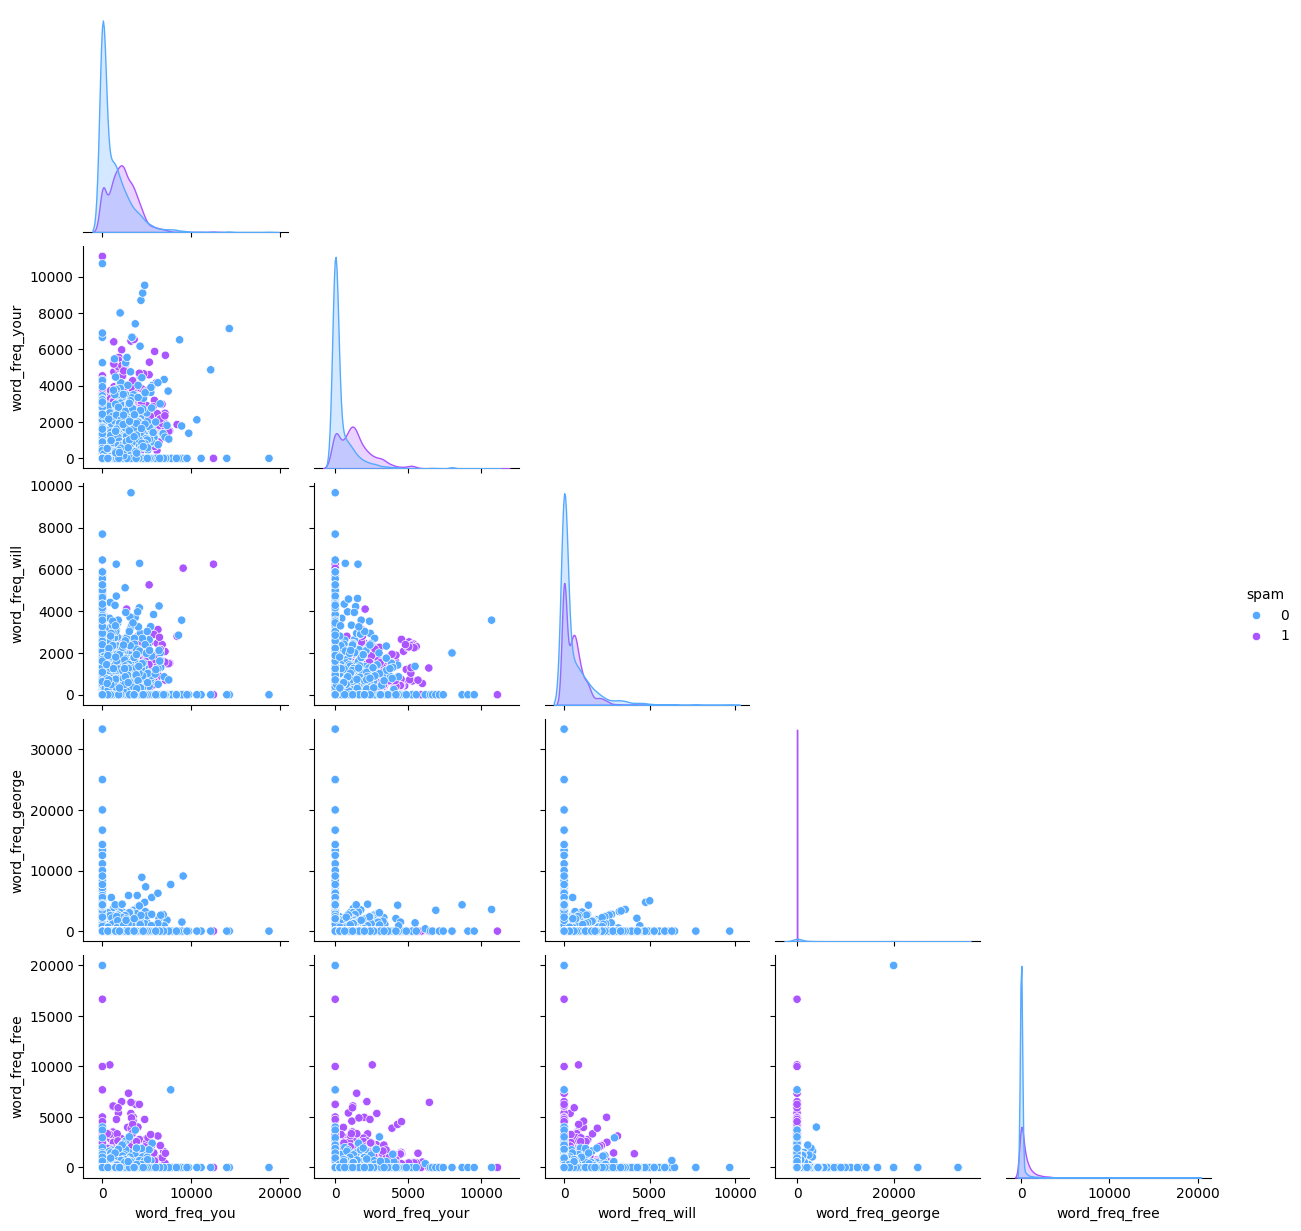

In [171]:
col_sel = ["word_freq_you", "word_freq_your", "word_freq_will", "word_freq_george", "word_freq_free", "spam"]
dataset_visualization = dataset[col_sel]

sns.pairplot(data=dataset_visualization, diag_kind="kde", hue="spam", palette="cool", corner=True);

### Preparación de los datos

Obtenemos los atributos y el target:

In [172]:
X = dataset.drop(columns="spam")
y = dataset["spam"]

### División del dataset en entrenamiento y evaluación

Dividimos el conjunto de datos en un conjunto de entrenamiento (70%) y uno de prueba (30%)

In [173]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

### Modelo Naive Bayes (Multinomial)
Entrenamos un clasificador de Bayes ingenuo multinomial

In [174]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Generamos las Predicciones y probabilidades

In [175]:
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

### Modelo Logistic Regression (con normalización)
Usamos un Pipeline con MinMaxScaler para normalizar y LogisticRegression para clasificar

In [176]:
lr_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("lr", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ]
)
lr_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Generamos las Predicciones y probabilidades

In [177]:
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

### Modelo Naive Bayes (Multinomial con normalización)

Usamos un Pipeline con MinMaxScaler para normalizar y MultinomialNB para clasificar

In [178]:
nb_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("lr", MultinomialNB())
    ]
)
nb_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Generamos las Predicciones y probabilidades

In [179]:
y_pred_nb_norm = nb_pipeline.predict(X_test)
y_proba_nb_norm = nb_pipeline.predict_proba(X_test)[:, 1]

### Cálculo de las matrices de Confusion

In [180]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_nb_norm = confusion_matrix(y_test, y_pred_nb_norm)

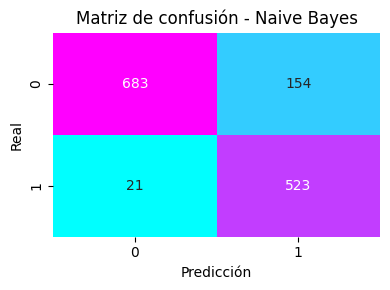

In [181]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Naive Bayes")

plt.tight_layout()
plt.show()

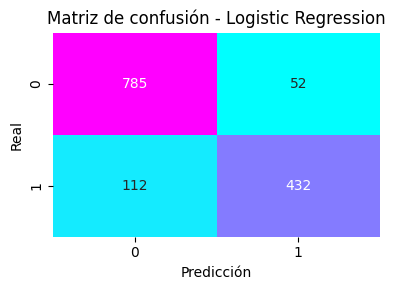

In [182]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Logistic Regression")

plt.tight_layout()
plt.show()

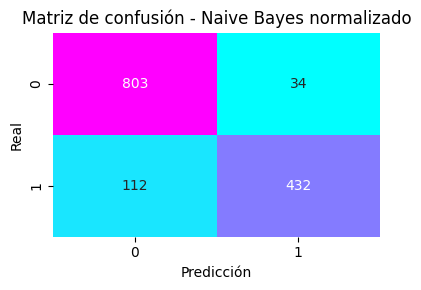

In [183]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_nb_norm, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Naive Bayes normalizado")

plt.tight_layout()
plt.show()

### Cálculo de las métricas

Como **scikit-learn** no ofrece funciones directas para el cálculo sensibilidad, especificidad y exactitud balanceada, las calculamos a partir de la matriz de confusión.

In [184]:
def sens_spec(cm):
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return sensitivity, specifity, balanced_accuracy

In [185]:
sensitivity_nb, specifity_nb, balanced_accuracy_nb = sens_spec(cm_nb)
sensitivity_lr, specifity_lr, balanced_accuracy_lr = sens_spec(cm_lr)
sensitivity_nb_norm, specifity_nb_norm, balanced_accuracy_nb_norm = sens_spec(cm_nb_norm)

In [186]:
print("Naive Bayes:")
print(f"Sensibilidad: {sensitivity_nb}")
print(f"Especificidad: {specifity_nb}")
print(f"Exactitud balanceada: {balanced_accuracy_nb}")
print("\nPrecision/Recall:")
target_names = ["NO SPAM", "SPAM"]
print(classification_report(y_test, y_pred_nb, target_names=target_names))
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
print(f"Naive Bayes -> precision={precision_nb:.4f}, recall={recall_nb:.4f}")

Naive Bayes:
Sensibilidad: 0.9613970588235294
Especificidad: 0.8160095579450418
Exactitud balanceada: 0.8887033083842857

Precision/Recall:
              precision    recall  f1-score   support

     NO SPAM       0.97      0.82      0.89       837
        SPAM       0.77      0.96      0.86       544

    accuracy                           0.87      1381
   macro avg       0.87      0.89      0.87      1381
weighted avg       0.89      0.87      0.87      1381

Naive Bayes -> precision=0.7725, recall=0.9614


In [187]:
print("Logistic Regression:")
print(f"Sensibilidad: {sensitivity_lr}")
print(f"Especificidad: {specifity_lr}")
print(f"Exactitud balanceada: {balanced_accuracy_lr}")
print("\nPrecision/Recall:")
target_names = ["NO SPAM", "SPAM"]
print(classification_report(y_test, y_pred_lr, target_names=target_names))
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Logistic Regression -> precision={precision_lr:.4f}, recall={recall_lr:.4f}")

Logistic Regression:
Sensibilidad: 0.7941176470588235
Especificidad: 0.937873357228196
Exactitud balanceada: 0.8659955021435097

Precision/Recall:
              precision    recall  f1-score   support

     NO SPAM       0.88      0.94      0.91       837
        SPAM       0.89      0.79      0.84       544

    accuracy                           0.88      1381
   macro avg       0.88      0.87      0.87      1381
weighted avg       0.88      0.88      0.88      1381

Logistic Regression -> precision=0.8926, recall=0.7941


In [188]:
print("Naive Bayes normalizado:")
print(f"Sensibilidad: {sensitivity_nb_norm}")
print(f"Especificidad: {specifity_nb_norm}")
print(f"Exactitud balanceada: {balanced_accuracy_nb_norm}")
print("\nPrecision/Recall:")
target_names = ["NO SPAM", "SPAM"]
print(classification_report(y_test, y_pred_nb_norm, target_names=target_names))
precision_nb_norm = precision_score(y_test, y_pred_nb_norm)
recall_nb_norm = recall_score(y_test, y_pred_nb_norm)
print(f"Naive Bayes normalizado -> precision={precision_nb_norm:.4f}, recall={recall_nb_norm:.4f}")

Naive Bayes normalizado:
Sensibilidad: 0.7941176470588235
Especificidad: 0.959378733572282
Exactitud balanceada: 0.8767481903155527

Precision/Recall:
              precision    recall  f1-score   support

     NO SPAM       0.88      0.96      0.92       837
        SPAM       0.93      0.79      0.86       544

    accuracy                           0.89      1381
   macro avg       0.90      0.88      0.89      1381
weighted avg       0.90      0.89      0.89      1381

Naive Bayes normalizado -> precision=0.9270, recall=0.7941


### Curvas de Precision-Recall

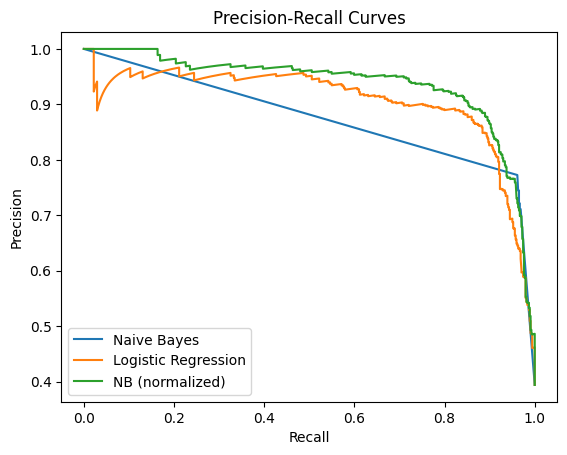

In [189]:
prec_nb, rec_nb, thr_nb = precision_recall_curve(y_test, y_proba_nb)
prec_lr, rec_lr, thr_lr = precision_recall_curve(y_test, y_proba_lr)
prec_nb_norm, rec_nb_norm, thr_nb_norm = precision_recall_curve(y_test, y_proba_nb_norm)

plt.figure()
plt.plot(rec_nb, prec_nb, label="Naive Bayes")
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_nb_norm, prec_nb_norm, label="NB (normalized)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best")
plt.show()

### Curva ROC y AUC

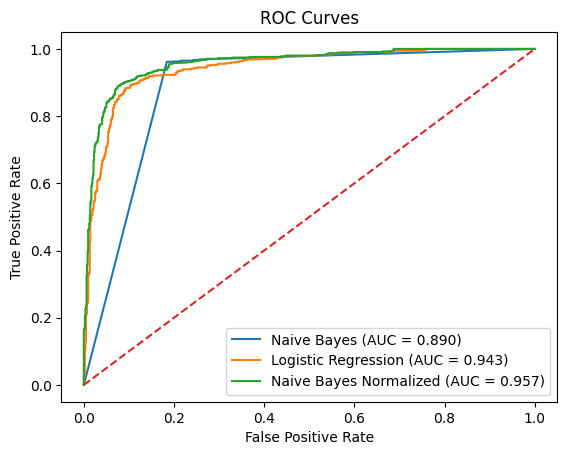


AUCs -> Naive Bayes: 0.8903, Logistic Regression: 0.9429, Naive Bayes Normalized: 0.9570


In [190]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb_norm, tpr_nb_norm, _ = roc_curve(y_test, y_proba_nb_norm)

auc_nb = roc_auc_score(y_test, y_proba_nb)
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_nb_norm = roc_auc_score(y_test, y_proba_nb_norm)

plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_nb_norm, tpr_nb_norm, label=f"Naive Bayes Normalized (AUC = {auc_nb_norm:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

print(f"\nAUCs -> Naive Bayes: {auc_nb:.4f}, Logistic Regression: {auc_lr:.4f}, Naive Bayes Normalized: {auc_nb_norm:.4f}")

### Análisis extra: busqueda de mejor umbral

Definimos métodos utiles para el análisis

In [191]:
def eval_at_threshold(y_true, y_scores, thr):
    # Evalúa calidad del modelo a un umbral dado
    y_pred = (y_scores >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    precision = (tp / (tp + fp)) if (tp + fp) else 0.0
    recall = (tp / (tp + fn)) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    return {"umbral": thr, "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "precision": precision, "recall": recall, "f1": f1}

In [192]:
def best_f1_point(y_true, y_scores):
    # Selecciona el umbral que maximiza F1
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    f1s = 2 * prec[:-1] * rec[:-1] / np.where((prec[:-1] + rec[:-1])==0, 1, (prec[:-1] + rec[:-1]))
    i = np.nanargmax(f1s)
    return eval_at_threshold(y_true, y_scores, thr[i])

In [193]:
def best_precision_at_recall(y_true, y_scores, min_recall=0.95):
    # Selecciona el umbral con mayor precision sujeto a recall >= min_recall
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    mask = rec[:-1] >= min_recall
    if not mask.any():
        j = np.argmax(rec[:-1])
        return eval_at_threshold(y_true, y_scores, thr[j])
    idxs = np.where(mask)[0]
    best = idxs[np.argmax(prec[idxs])]
    return eval_at_threshold(y_true, y_scores, thr[best])

Evaluamos cada modelo en distintos umbrales

In [194]:
pt_nb_05 = eval_at_threshold(y_test, y_proba_nb, 0.5)
pt_lr_05 = eval_at_threshold(y_test, y_proba_lr, 0.5)
pt_nb_norm_05 = eval_at_threshold(y_test, y_proba_nb_norm, 0.5)

pt_nb_maxf1 = best_f1_point(y_test, y_proba_nb)
pt_lr_maxf1 = best_f1_point(y_test, y_proba_lr)
pt_nb_norm_maxf1 = best_f1_point(y_test, y_proba_nb_norm)

pt_nb_hiR = best_precision_at_recall(y_test, y_proba_nb, min_recall=0.95)
pt_lr_hiR = best_precision_at_recall(y_test, y_proba_lr, min_recall=0.95)
pt_nb_norm_hiR = best_precision_at_recall(y_test, y_proba_nb_norm, min_recall=0.95)

op_table = pd.DataFrame([
    {"modelo":"Naive Bayes", "policy":"thr=0.5", **pt_nb_05},
    {"modelo":"Logistic Regression", "policy":"thr=0.5", **pt_lr_05},
    {"modelo":"Naive Bayes normalizado", "policy":"thr=0.5", **pt_nb_norm_05},
    {"modelo":"Naive Bayes", "policy":"max F1", **pt_nb_maxf1},
    {"modelo":"Logistic Regression", "policy":"max F1", **pt_lr_maxf1},
    {"modelo":"Naive Bayes normalizado", "policy":"max F1", **pt_nb_norm_maxf1},
    {"modelo":"Naive Bayes", "policy":"recall≥0.95", **pt_nb_hiR},
    {"modelo":"Logistic Regression", "policy":"recall≥0.95", **pt_lr_hiR},
    {"modelo":"Naive Bayes normalizado", "policy":"recall≥0.95", **pt_nb_norm_hiR},
]).round(4)

print("\nOperating points (threshold policies)")
print(op_table.to_string(index=False))


Operating points (threshold policies)
                 modelo      policy  umbral  TP  FP  TN  FN  precision  recall     f1
            Naive Bayes     thr=0.5  0.5000 523 154 683  21     0.7725  0.9614 0.8567
    Logistic Regression     thr=0.5  0.5000 432  52 785 112     0.8926  0.7941 0.8405
Naive Bayes normalizado     thr=0.5  0.5000 432  34 803 112     0.9270  0.7941 0.8554
            Naive Bayes      max F1  1.0000 523 154 683  21     0.7725  0.9614 0.8567
    Logistic Regression      max F1  0.4051 480  77 760  64     0.8618  0.8824 0.8719
Naive Bayes normalizado      max F1  0.4523 484  63 774  60     0.8848  0.8897 0.8873
            Naive Bayes recall≥0.95  1.0000 523 154 683  21     0.7725  0.9614 0.8567
    Logistic Regression recall≥0.95  0.2480 517 228 609  27     0.6940  0.9504 0.8022
Naive Bayes normalizado recall≥0.95  0.3982 518 158 679  26     0.7663  0.9522 0.8492
